In [1]:
from datetime import date

import pandas as pd
import numpy as np

from matplotlib.pylab import plt
from matplotlib import colors

from IPython.display import Image



import seaborn as sns

import requests
import json

sns.set_style("white")

sns.set_context("paper")
dpi = 200
figsize=(15, 6)


%matplotlib inline

# A Colour-Coded Segmented Bar Chart
I've been doing a lot of COVID-19 analysis recently, mostly as a persona project, but I thik it will also form the basis of a 3rd year undergraduate data science course that I will be teaching in Spring 2021.
Over the weekend I needed to produce a particular type of bar graph for a blog post that I was working on. The specification of what I needed goes as follows:

1. I want bar graph in which each bar reflects the total mobility drop experienced by a country over the duration of their COVID-19 lockdown; I was using Google's and Apple's mobility datasets for this.
2. I wanted each bar to be segmented so that each segment reflected the mobility drop in each consecutive week of their lockdown; in other words, is a lockdown was 10 weeks long then the bar would be made up of 10 segments.
3. Finally, I wanted to colour-code each individual bar (not segment) to reflect its deaths per capital.

To cut to the chase here is the final product that I wanted, with each bar segmented and coloured as required.

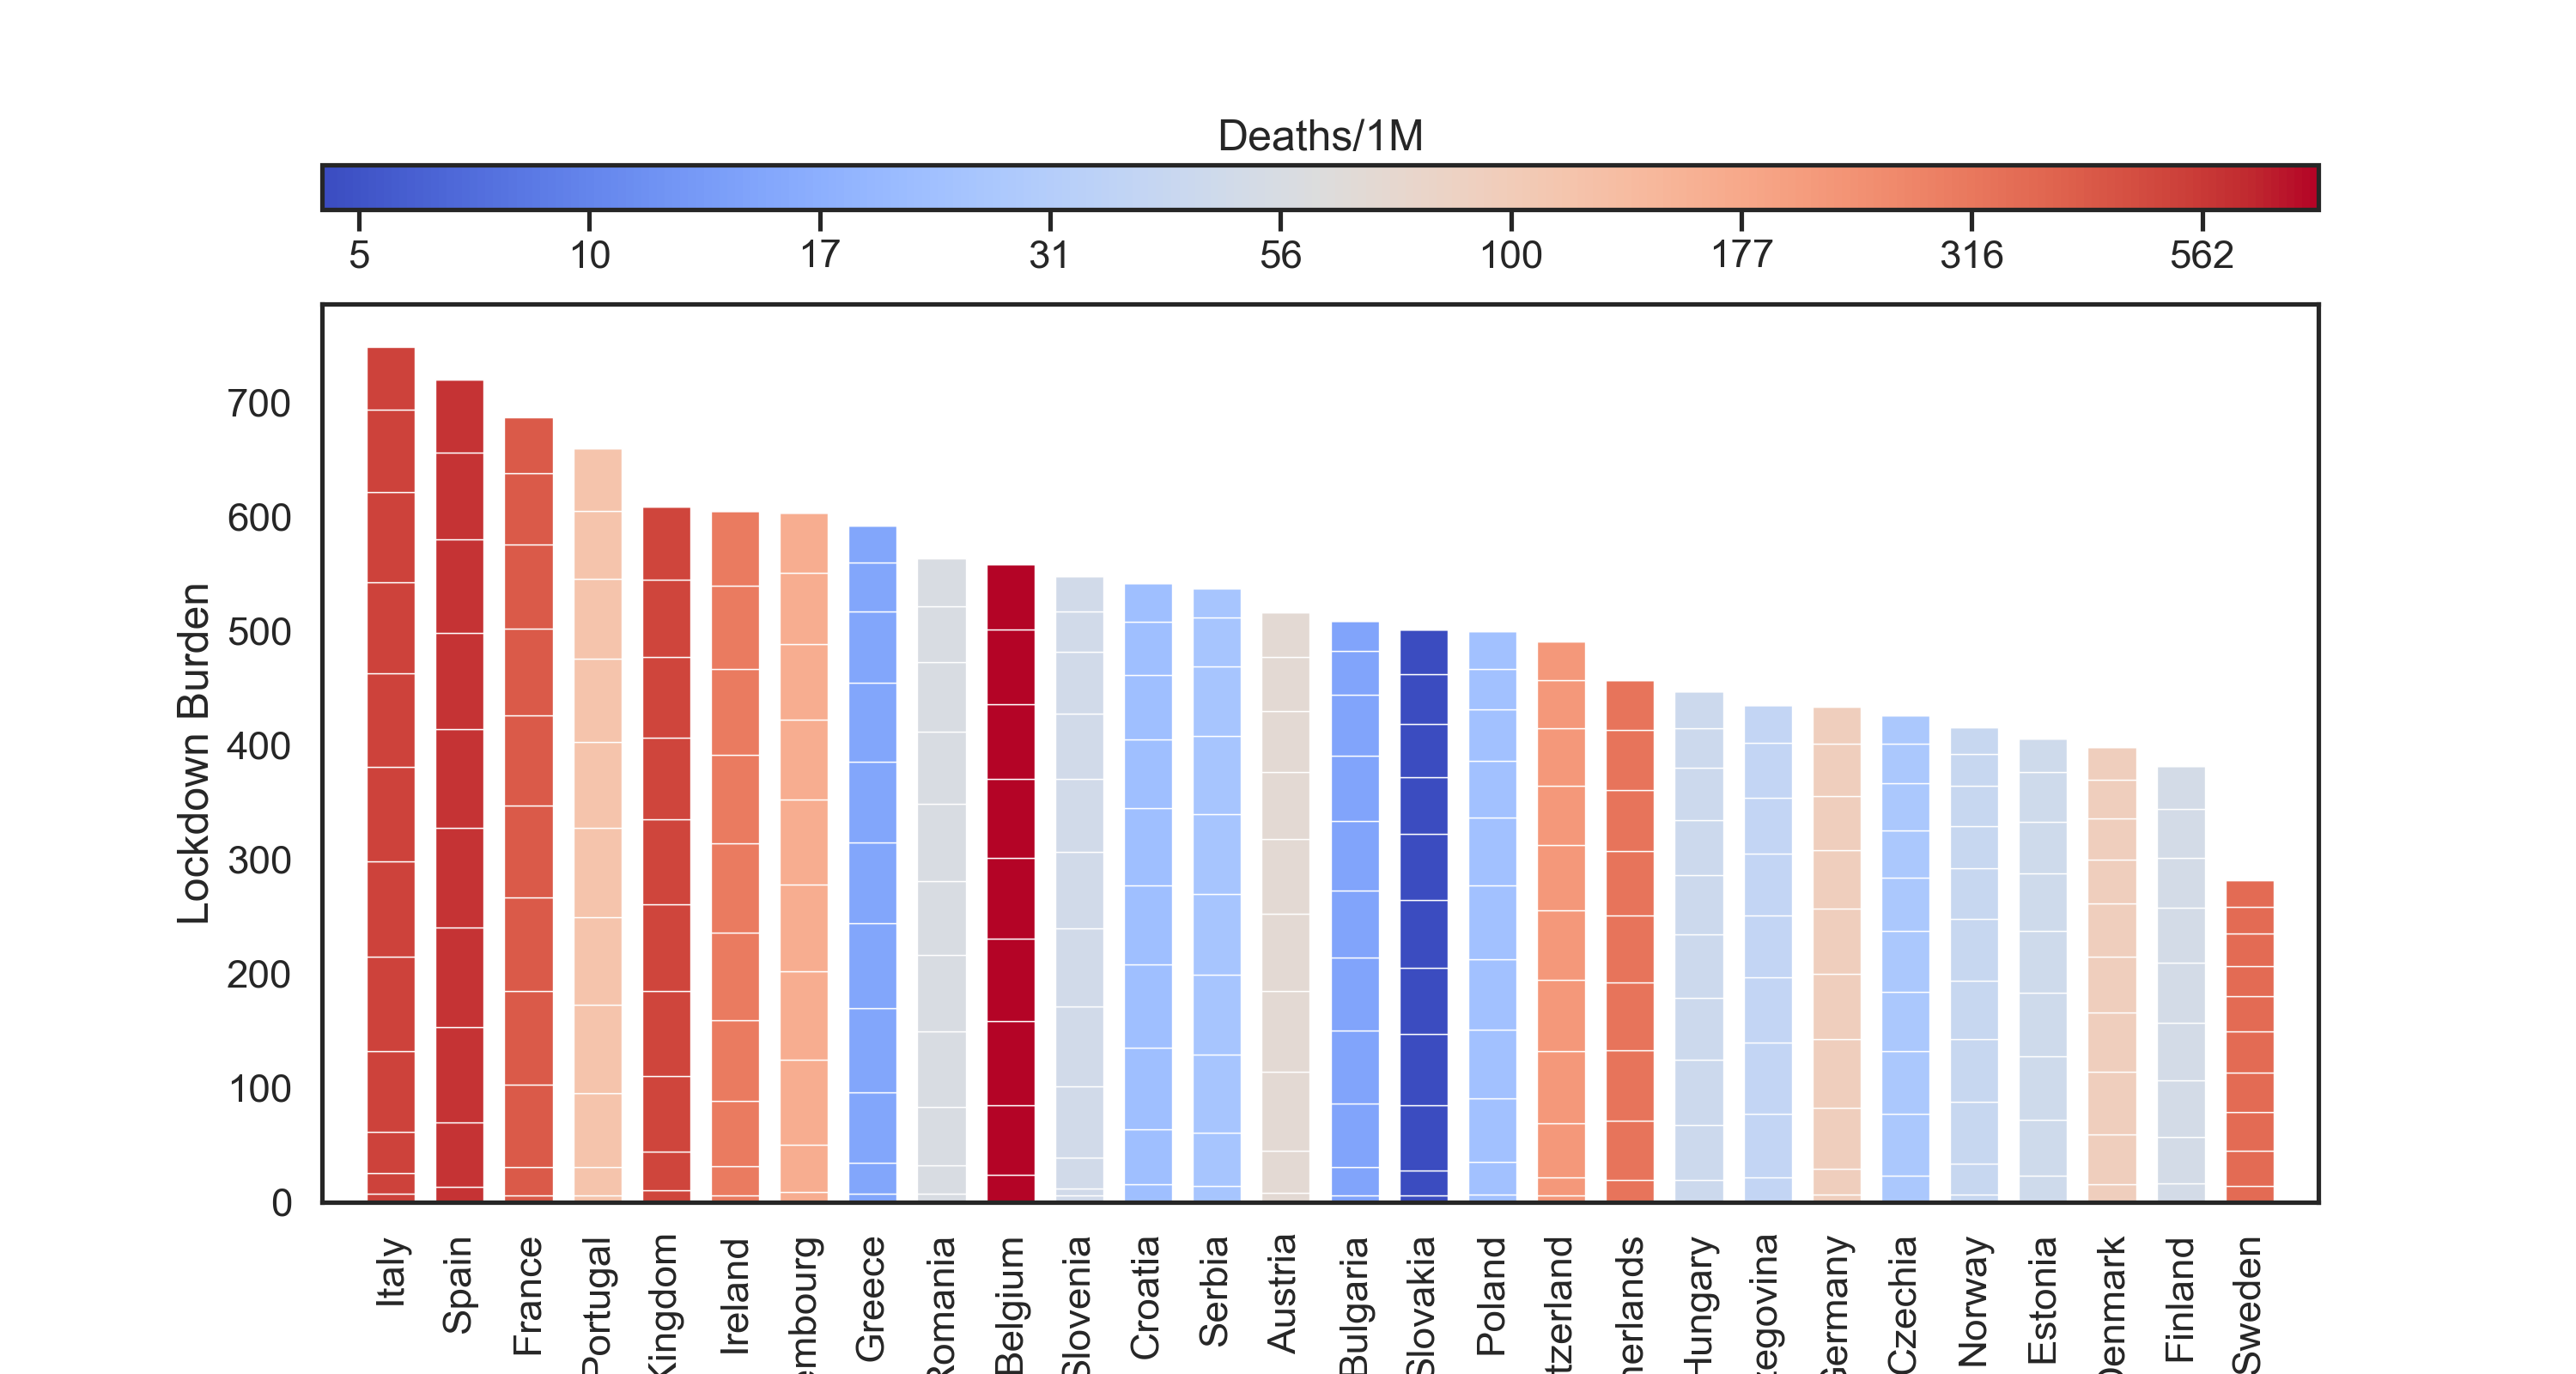

In [2]:
Image("../images/segmented_bar_graph.png", width=800)

At first I assumed this would be possible as a variation on a stacked bar chart but after a bit of searching I reached the conclusion that this was not the case. Although a stacked bar chart can deliver the segmented effect it is not possible to individually colour the bars; instead a stacked bar chart colours the segments (in order) so that each bar is made up of a set of multi-coloured segments. I though that a heatmap might also do the trick but that doesn't work because it assumes fixed sized cells.

So instead I came up with a solution, which I will now share, because it may be useful to others or, even better, perhaps someone will tell me that there is another way to achieve the same result.



# Sample data

To begin, here is a sample of the dataset that I am using. Each row corresponds to a country. There is a column for the log of the number of deaths per million in that country (as of mid-May 2020) and also a set of columns with the average percentage mobility drop for each week of a country's lockdown, based on the number of week prior to the country's 100th confirmed case. So, for example, Austria's death toll is approximately 1,84 deaths per million and it's lockdown began during the week when Austria recorded its 100th death. That week (week 0) there was a 8% drop in mobility (relative to pre-lockdown levels) and over the next few weeks Austria's mobility levels fell by a peak of just over 70% (week 3).

In [3]:
df = pd.read_csv('../data/segmented_bar_graph_example_data.csv').set_index('country').fillna(0)
df.head()

,log_deaths,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
country,,,,,,,,,,,,,,,
Austria,1.844600,0.000000,0.000000,8.235322,36.764971,69.240609,70.890130,67.479268,64.958915,58.422410,53.599753,47.547835,38.687741,0.0,0.0
Belgium,2.876030,0.000000,0.000000,0.000000,23.783895,61.425109,73.137514,72.631807,70.428046,68.985395,65.570381,64.691677,57.261499,0.0,0.0
Bosnia_and_Herzegovina,1.594080,0.000000,21.579365,56.047619,62.000000,56.904762,54.455782,54.088435,48.653061,48.020408,32.809524,0.000000,0.000000,0.0,0.0
Bulgaria,1.178666,6.374071,24.740646,55.040751,64.342249,63.764265,58.494731,60.585141,57.224373,53.286671,38.377283,26.071429,0.000000,0.0,0.0
Croatia,1.363859,0.000000,15.606125,48.428781,71.536722,72.473454,69.412617,67.156906,60.601690,56.363933,45.961587,33.793651,0.000000,0.0,0.0


Obviously, to produce the bars we will use the weekly mobility drop values as the heigh of each bar segment and then the death rate will be used to colour-code these bars. Incidentally, we use the log of the death rate here only to emphasise differences between death rates given that that the raw deaths per million values are wide ranging in the countries being analysed (from <5 to >500) and th elog scale helps to 'spread' these out a bit.

To keep things simple lets separate out the weekly mobility data and the deaths.

We need to sort the weekly data based on the sum of the weekly values for each country (total height of the bars). A one-liner to do this involves using Pandas assign to create a temporary column based on the sum of the weekly data so that we can sort by this column and then ditch it afterwards using drop.

In [4]:
weeklies = df.drop(columns=['log_deaths']).assign(s=df.sum(axis=1)).sort_values('s', ascending=False).drop('s', axis=1)
weeklies.head()

,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
country,,,,,,,,,,,,,,
Italy,0.0,0.000000,7.838259,17.559235,36.115503,71.044683,81.921737,83.611863,82.577606,82.233103,79.772614,78.187686,72.353386,54.991350
Spain,0.0,0.000000,0.000000,13.514706,56.319504,83.610978,86.633163,87.414035,86.463850,83.988378,81.791387,76.064994,63.595238,0.000000
France,0.0,0.000000,0.000000,5.823090,24.977370,71.923062,82.365984,81.526320,80.514407,78.459459,75.887086,73.553137,62.590882,49.285714
Portugal,0.0,5.841252,24.730155,65.193727,76.842267,77.067487,78.179867,75.063611,72.362051,70.279343,59.337758,54.309524,0.000000,0.000000
United_Kingdom,0.0,0.000000,0.000000,10.500087,34.033735,65.632583,74.858312,75.304424,74.332446,71.599056,70.717291,67.628471,63.857143,0.000000


In [5]:
# Use the sorted index from weeklies to sort deaths in the same way.
deaths = df.loc[weeklies.index]['log_deaths']
deaths.head()

country
Italy             2.717928
Spain             2.769666
France            2.624993
Portugal          2.071556
United_Kingdom    2.706952
Name: log_deaths, dtype: float64

# The Segmented Bar
To build our segmented bar 

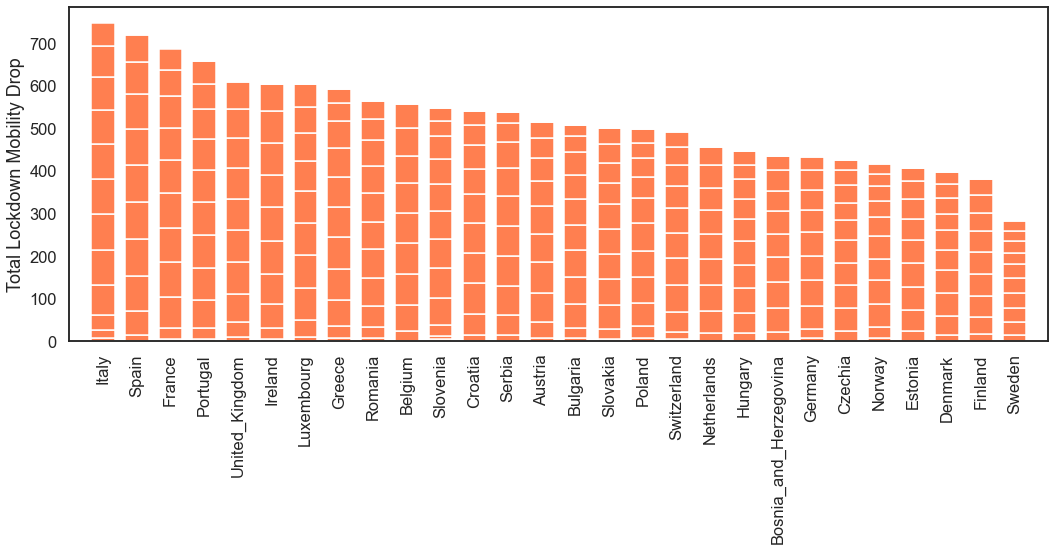

In [6]:
sns.set_context('talk')
                
fig, ax = plt.subplots(figsize=(15,8))

# Plot the segments as a stacked bar for a given x coordinate.
# Each x coordinate value will correspond to a country in our dataset.
def plot_segments(ax, x, segments, width=0.7, min_y=0):
    
    current_y = min_y  # The base of each bar.
    
    # Stack each segment.
    for segment in segments:
        
        # Plot a single bar at x with height=segment and its base at current_y
        ax.bar([x], [segment], width, bottom=current_y, color='coral')
        
        # Update current_y so that the next segment is plotted on top.
        current_y += segment
        

# Plot each of the country's segments using apply.
weeklies.apply(lambda segments: plot_segments(ax, segments.name, segments), axis=1)


# Rotate the x-axis labels for a better fit.
[label.set_rotation(90) for label in ax.get_xticklabels()]

ax.set_xlim(-1, len(weeklies))
ax.set_ylabel('Total Lockdown Mobility Drop')

fig.tight_layout()

This is most of the way there in the sense that we have created the segmented bars that are required and each bar (in fact each segment of each bar) is individually addressable. We want to colour each bar based on the deaths data and we can do this by setting up a simple colour map.

# Colouring the Bars

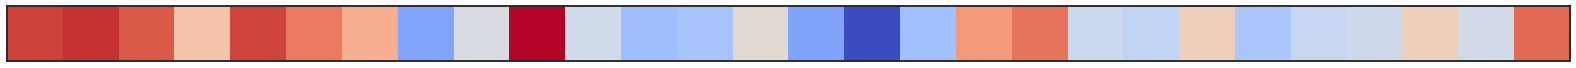

In [7]:
# Use the coolwarm colour map, which comes with Matplotlib.
cmap = plt.cm.coolwarm

# Normalise the log-deaths into a 0, 1 scale
norm = colors.Normalize(vmin=deaths.min(), vmax=deaths.max())

# Now the ith colour in colours corresponds to the ith country in deaths.
colours = cmap(norm(deaths))

# Build a simple colour dictionary indexed by country name.
colour_dict = dict(zip(deaths.index, colours))

# Display the colours. These are in order of the countries in our deaths/weeklies series/dataframe.
sns.palplot(colours)

Now all we need to do is to change one line of the plot_segments function so that instead of using a fixed colour we pull the colour we need from the colour dictionary; we should also pass this into the function. Remember that x is the country name.

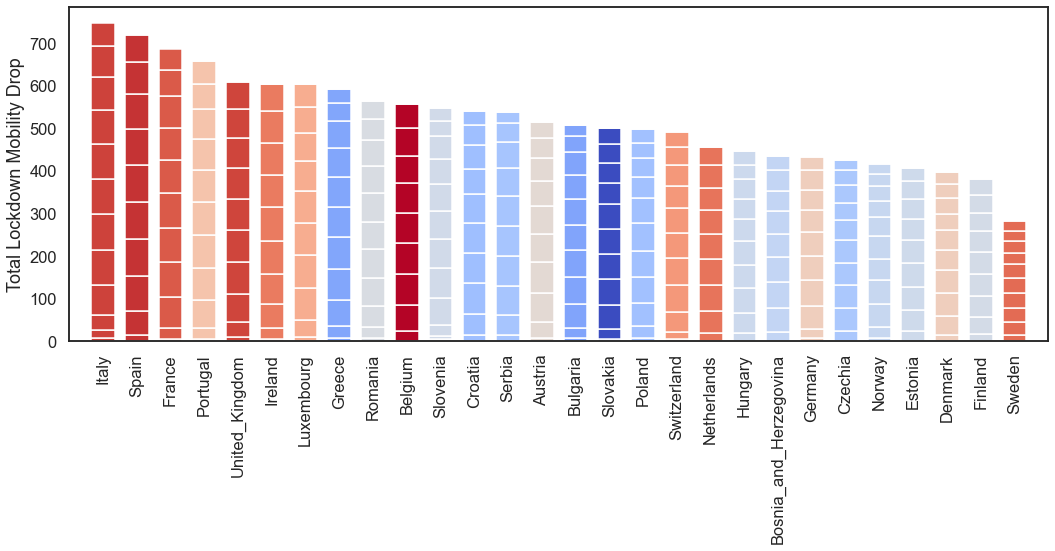

In [8]:
sns.set_context('talk')
                
fig, ax = plt.subplots(figsize=(15,8))

# Plot the segments as a stacked bar at the x coordinate.
def plot_segments(ax, x, segments, width=0.7, min_y=0, colour_dict=colour_dict):
    current_y = min_y
    for segment in segments:
        
        # Plot a single bar at x with height=segment and its base at current_y
        # Colour the bar based on the colour code for x
        ax.bar([x], [segment], width, bottom=current_y, color=colour_dict[x])
        
        # Update current_y so that the next segment is plotted on top.
        current_y += segment
        
# Plot each of the country's segments using apply.
weeklies.apply(lambda segments: plot_segments(ax, segments.name, segments), axis=1)

# Rotate the x-axis labels for a better fit.
[label.set_rotation(90) for label in ax.get_xticklabels()]

ax.set_xlim(-1, len(weeklies))
ax.set_ylabel('Total Lockdown Mobility Drop')

fig.tight_layout()

# Adding the Colour Key

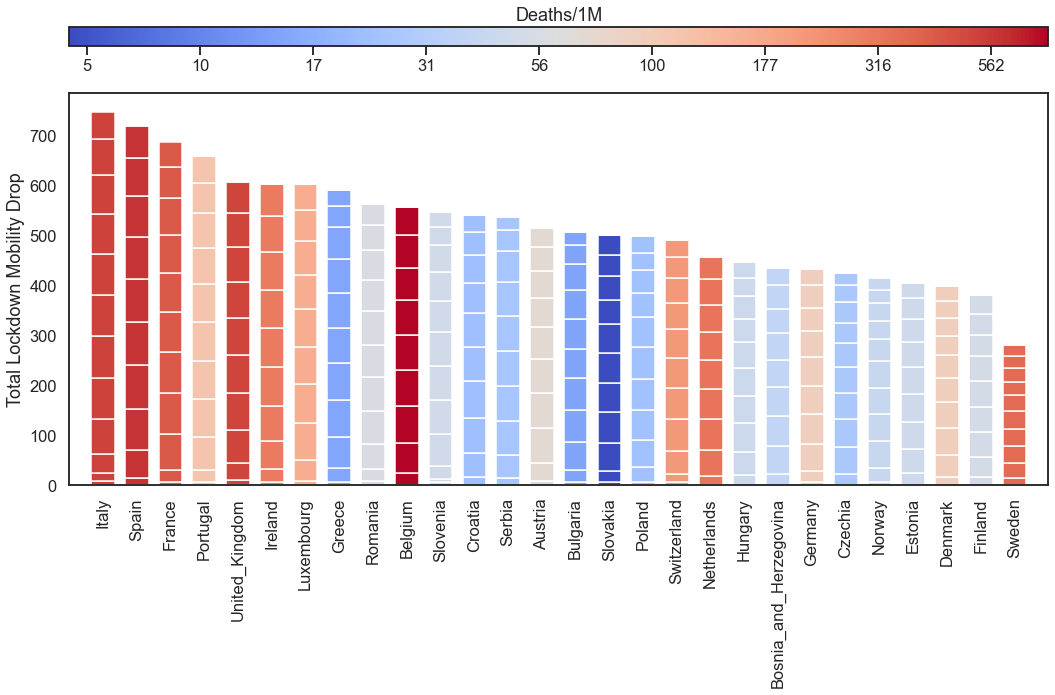

In [9]:
sns.set_context('talk')
                
# Create 2-row gridspec to hold the colour bar (cax) and the main graph (ax)
fig, (cax, ax) = plt.subplots(nrows=2,figsize=(15,10), gridspec_kw={"height_ratios":[.05, 1]})

# --- Creating the  colour map
# Use the coolwarm colour map, which comes with Matplotlib.
cmap = plt.cm.coolwarm

# Normalise the log-deaths into a 0, 1 scale
norm = colors.Normalize(vmin=deaths.min(), vmax=deaths.max())

# Now the ith colour in colours corresponds to the ith country in deaths.
colours = cmap(norm(deaths))

# Build a simple colour dictionary indexed by country name.
colour_dict = dict(zip(deaths.index, colours))


# --- Plotting the segments
# Plot the segments as a stacked bar at the x coordinate.
def plot_segments(ax, x, segments, width=0.7, min_y=0, colour_dict=colour_dict):
    current_y = min_y
    for segment in segments:
        
        # Plot a single bar at x with height=segment and its base at current_y
        # Colour th ebar based on the colour code for x
        ax.bar([x], [segment], width, bottom=current_y, color=colour_dict[x])
        
        # Update current_y so that the next segment is plotted on top.
        current_y += segment
        
# Plot each of the country's segments using apply.
weeklies.apply(lambda segments: plot_segments(ax, segments.name, segments), axis=1)


# --- Axes
# Rotate the x-axis labels for a better fit.
[label.set_rotation(90) for label in ax.get_xticklabels()]

ax.set_xlim(-1, len(weeklies))
ax.set_ylabel('Total Lockdown Mobility Drop')


# --- Adding the colour bar
colour_scale = plt.cm.ScalarMappable(cmap=cmap, norm=norm)  # Create the colour scale
cbar = plt.colorbar(colour_scale, cax=cax, orientation="horizontal")  # Add the bar

# Add the title
cbar.ax.set_title('Deaths/1M')

# Since the deaths are in log base 10 right now, let's transform them back into 
# deaths per million.
ticks = [int(10**n) for n in cbar.get_ticks()]
cbar.ax.set_xticklabels(ticks)

fig.tight_layout()